In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import OneClassSVM
from sklearn.datasets import load_iris
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture

from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pydvl.value import compute_data_oob
from pydvl.utils import Dataset, Utility, Scorer
from pydvl.reporting.scores import compute_removal_score
from pydvl.reporting.plots import shaded_mean_std, plot_best_worst, plot_best_worst_class_imbalance, compute_best_worst_scores, plot_methods_linreg
from pydvl.value.result import ValuationResult

import pandas as pd

import random
from tqdm import tqdm
# synthcity absolute

import synthcity.logger as log
from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import GenericDataLoader

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [2]:
data = Dataset.from_sklearn(load_iris())

In [3]:


#model = KNeighborsClassifier(n_neighbors=5)
#model = DecisionTreeClassifier(max_depth=5,)
#model = LogisticRegression()
model = GaussianMixture
#model = Plugins().get("ctgan")

utility = Utility(model, data, Scorer("accuracy", default=0.0))

In [4]:
from pydvl.value.oob.oob import compute_data_oob_generative

In [5]:
ad_dict={"model":IsolationForest, "kwargs":{"contamination":0.2}}
ad_dict["kwargs"]

{'contamination': 0.2}

In [12]:
oob_values = compute_data_oob_generative(utility, progress=True, max_samples=0.8, n_est=30, eval_alg="custom", ad_dict=ad_dict)

100%|██████████| 30/30 [00:09<00:00,  3.30it/s]


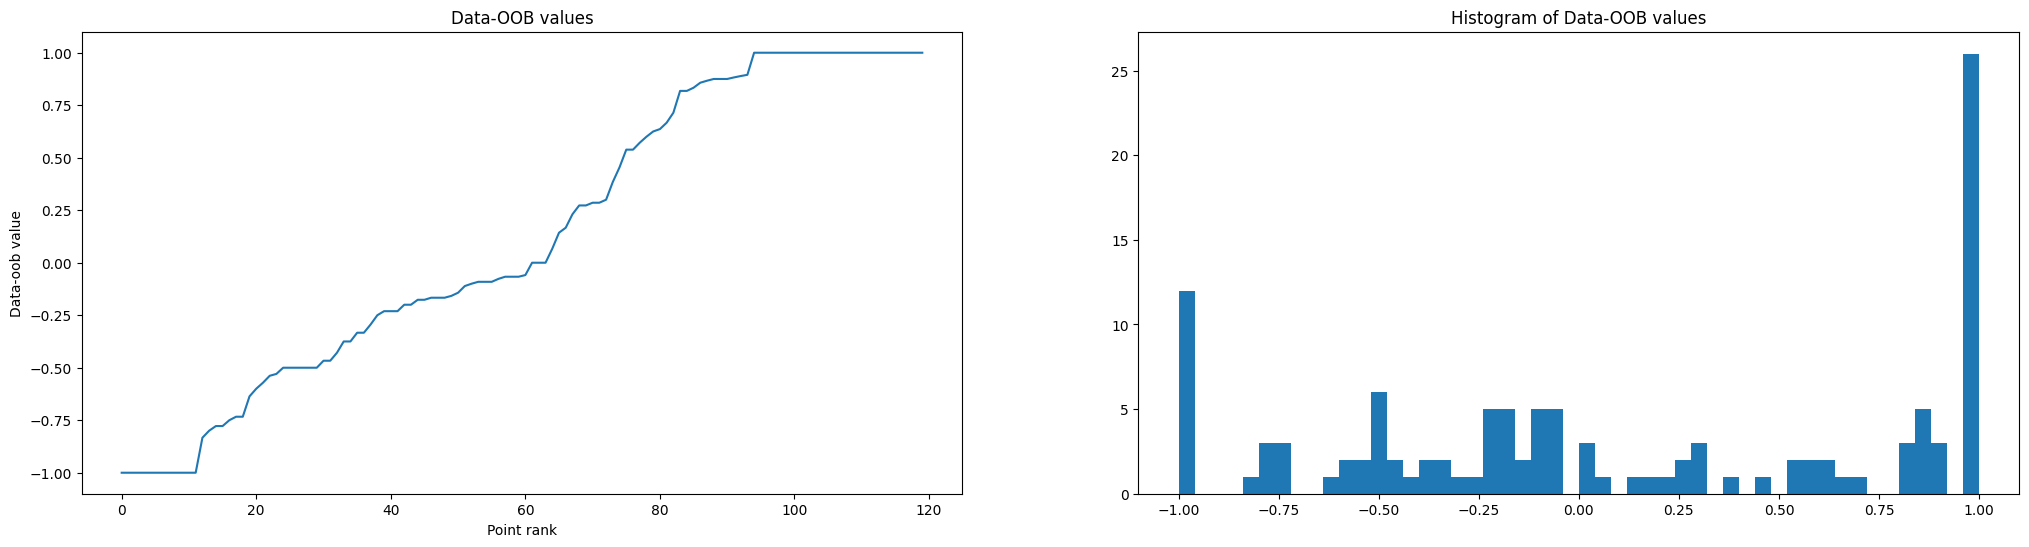

In [13]:
oob_values.sort(key="value")
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[25, 6])

ax[0].plot(np.arange(len(oob_values.values)), oob_values.values)
ax[0].set_title("Data-OOB values")
ax[0].set_ylabel("Data-oob value")
ax[0].set_xlabel("Point rank");

ax[1].hist(oob_values.values, bins=50)
ax[1].set_title("Histogram of Data-OOB values");

In [14]:
df = pd.DataFrame(utility.data.x_train, columns=utility.data.feature_names)
df.loc[:,"values"] = oob_values.to_dataframe()["data_oob"]
df.loc[:,"values"].fillna(1)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),values
0,5.7,2.6,3.5,1.0,1.000000
1,6.7,3.0,5.2,2.3,0.285714
2,6.1,2.6,5.6,1.4,0.636364
3,5.6,2.7,4.2,1.3,1.000000
4,6.0,2.2,4.0,1.0,0.000000
...,...,...,...,...,...
115,5.8,2.7,4.1,1.0,1.000000
116,5.8,2.7,3.9,1.2,1.000000
117,6.1,2.8,4.0,1.3,1.000000
118,5.1,3.5,1.4,0.3,-0.066667


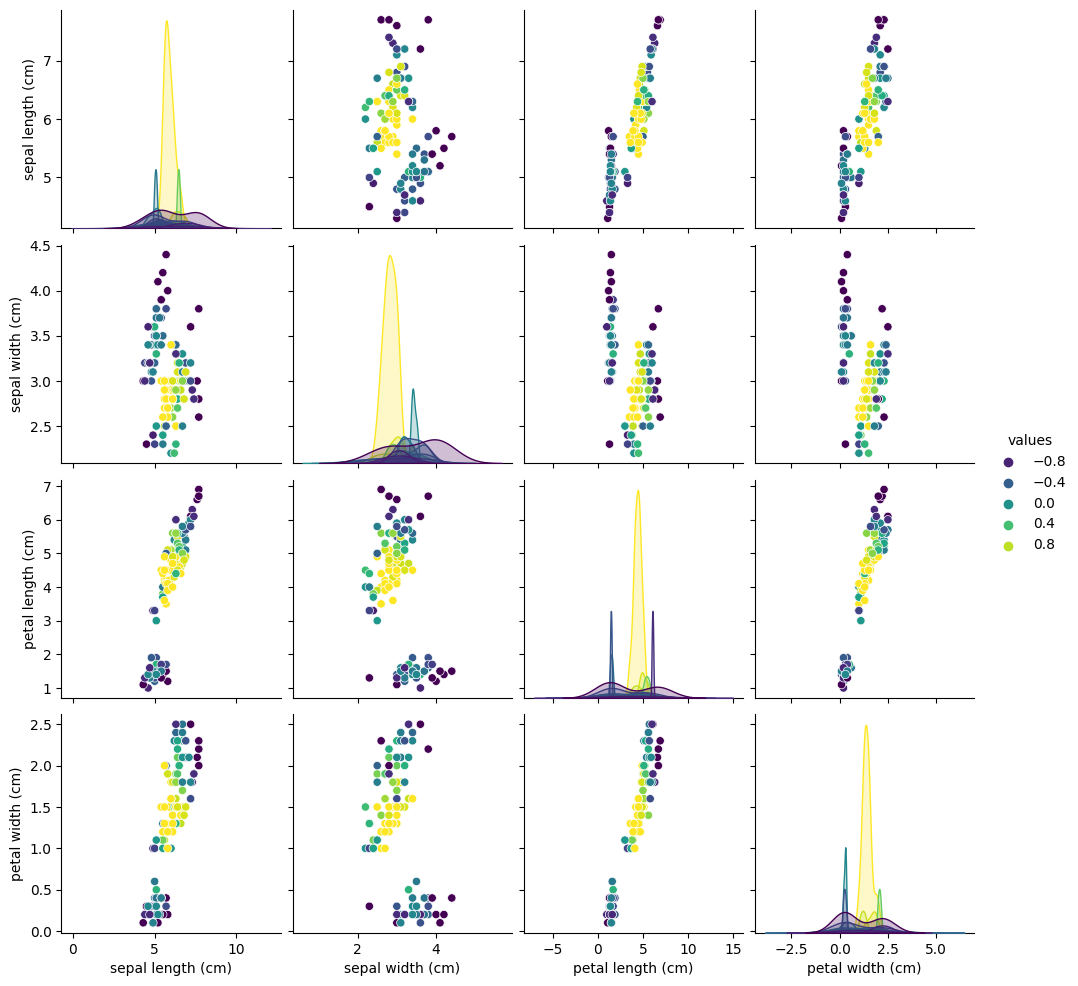

In [15]:
sns.pairplot(data=df, hue="values", palette="viridis")

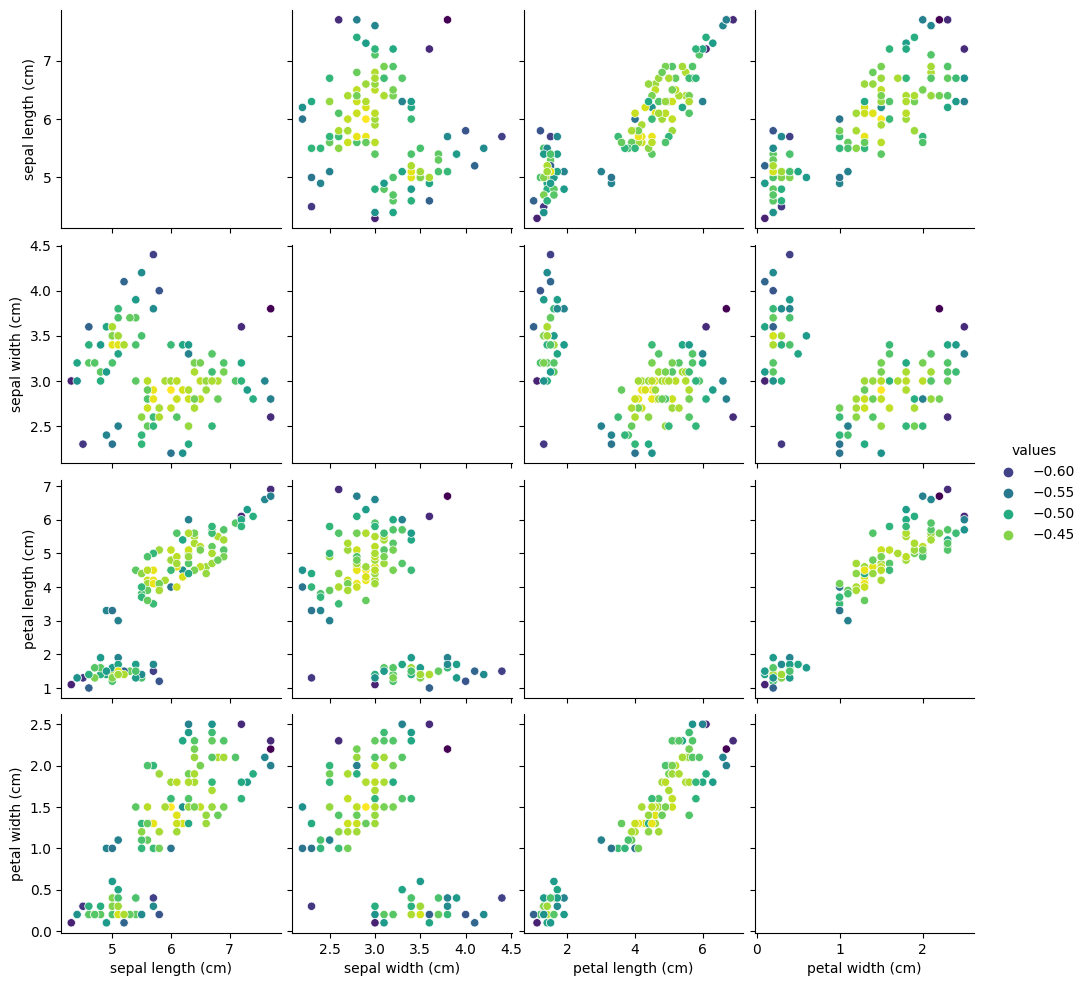

In [16]:
df = pd.DataFrame(utility.data.x_train, columns=utility.data.feature_names)
df.loc[:,"values"] = IsolationForest().fit(utility.data.x_train).score_samples(utility.data.x_train)
sns.pairplot(data=df, hue="values", palette="viridis")

## Variance

The variance it the weak learner variance. It is computed with Welford's online algorithm.

In [17]:
plot_list = [(a, b) for a, b in zip(oob_values.values, oob_values.variances)]
plot_list = pd.DataFrame(plot_list).sample(100).sort_values(by=0).values
yerr = [x[1] ** 2 for x in plot_list]

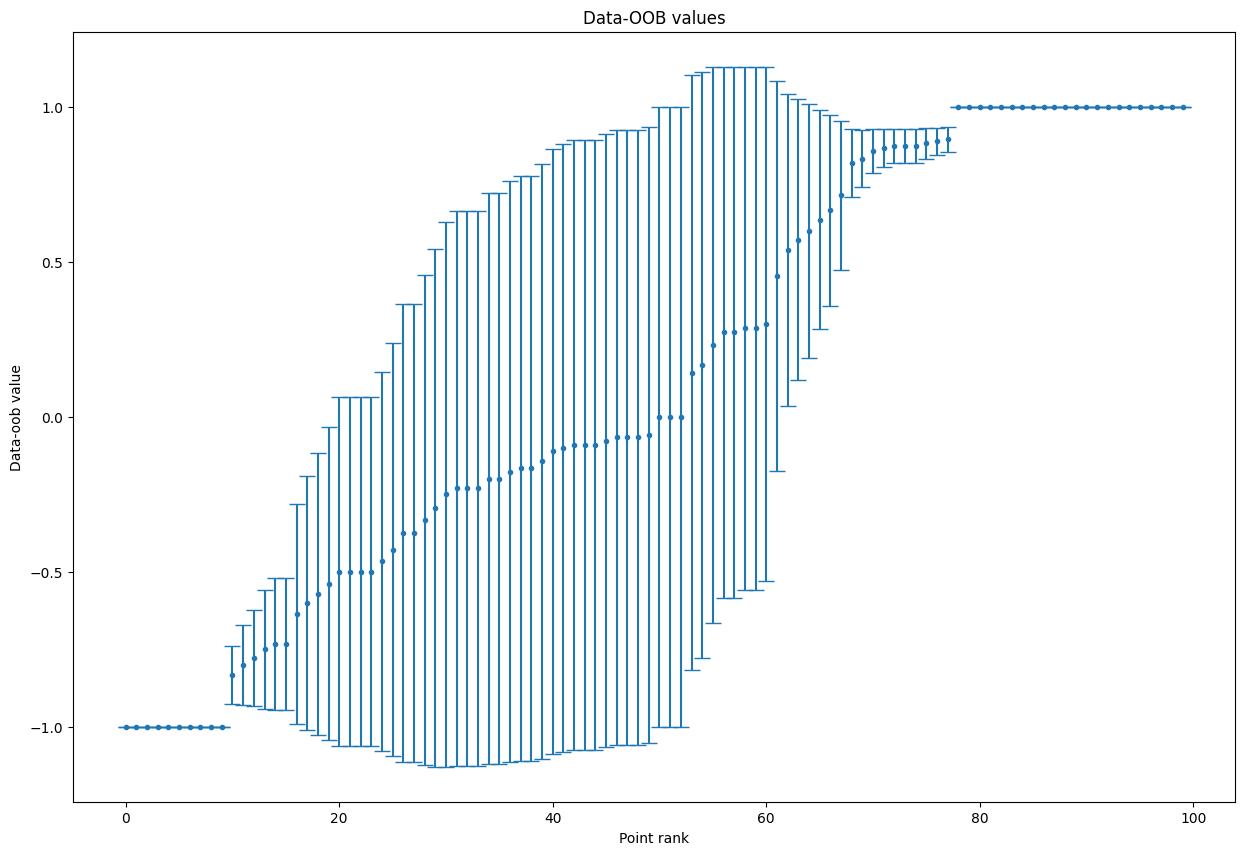

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 10])
ax.errorbar(
    x=np.arange(len(yerr)), y=[x[0] for x in plot_list], yerr=yerr, fmt=".", capsize=6
)
plt.title("Data-OOB values")
ax.set_ylabel("Data-oob value")
ax.set_xlabel("Point rank");

# Point removal

In [19]:
from pydvl.reporting.plots import compute_best_worst_scores, plot_best_worst_class_imbalance

In [20]:
def oob_func(utility, n_est):
    return(compute_data_oob_generative(utility, n_est=n_est, max_samples=0.4, progress=True))
n_est_list = [10, 20, 30]
func = oob_func
kwargs_list = [{"n_est":n_est} for n_est in n_est_list]

In [22]:
model_eval = DecisionTreeClassifier(max_depth=3)
utility_eval = Utility(model_eval, data, Scorer("accuracy", default=0.0))
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.01)
best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility, removal_percentages, n_iter, oob_func, kwargs_list, f_name="oobGen", return_values=True)

100%|██████████| 30/30 [00:01<00:00, 21.13it/s]


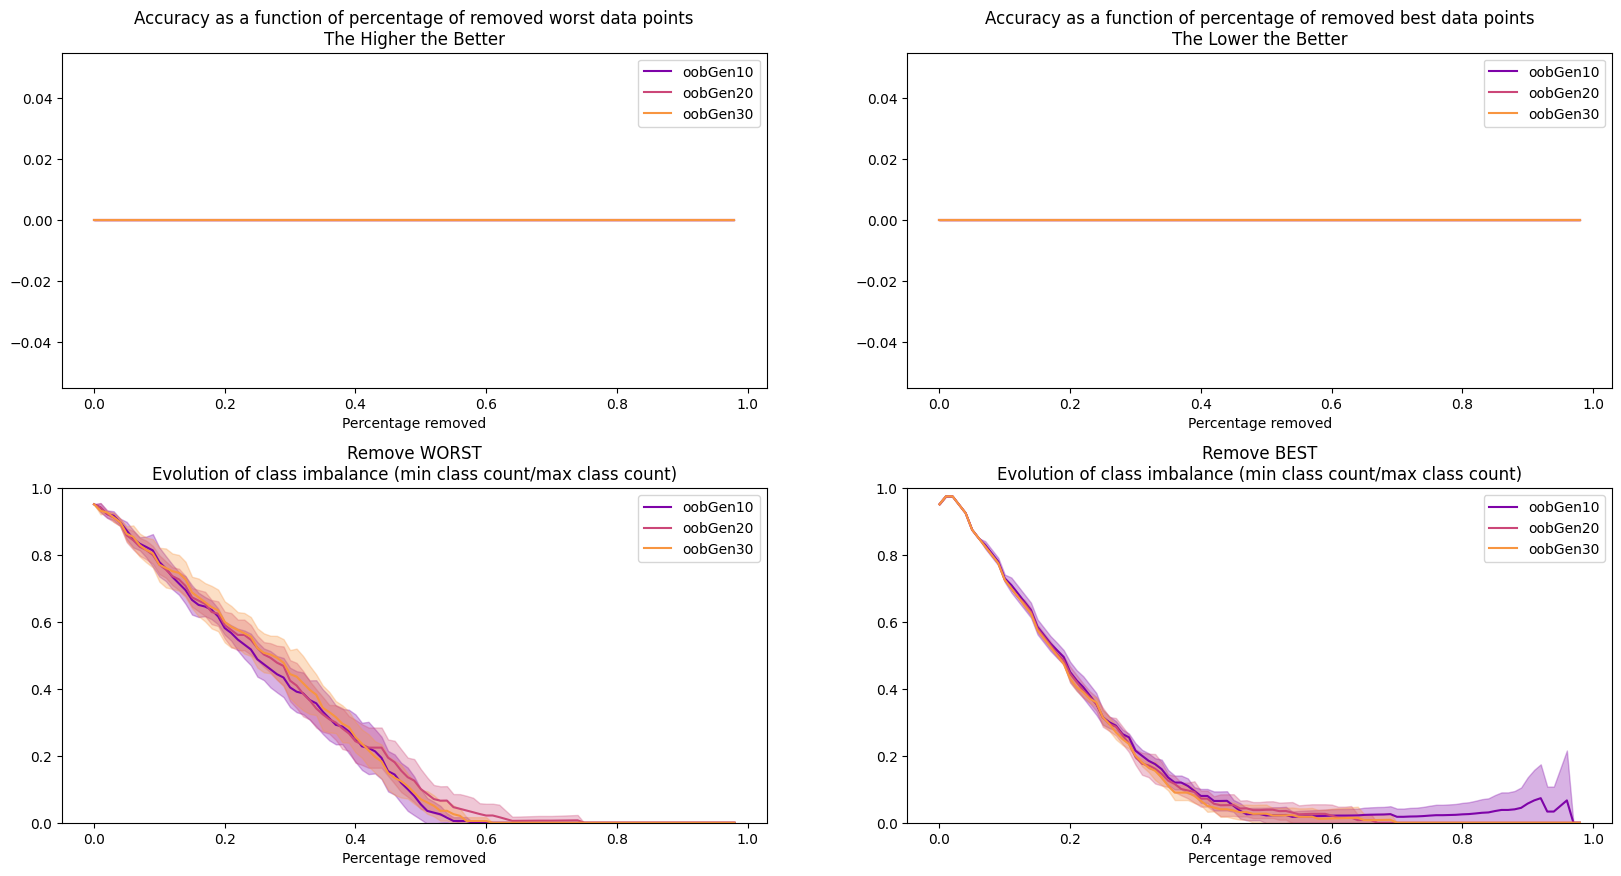

In [24]:
plot_best_worst_class_imbalance(best_scores_df, worst_scores_df, all_values, utility, palette_name="plasma")

# Eval 

## Removal based metric:

In [25]:
model_class = GaussianMixture
m = model_class()

In [26]:
from sdmetrics.single_table import SVCDetection, CorrelationSimilarity, LogisticDetection, KSComplement, StatisticSimilarity, BoundaryAdherence
from sdv.metrics.tabular import BinaryDecisionTreeClassifier

In [ ]:
from typing import Dict, Iterable, Union
from pydvl.utils import Utility, maybe_progress
from numpy.typing import NDArray

def compute_gen_scores(
    u: Utility,
    values: ValuationResult,
    percentages: Union[NDArray[np.float_], Iterable[float]],
    *,
    remove_best: bool = False,
    metric,
    progress: bool = False,
) -> Dict[float, float]:
    
    # Sanity checks
    if np.any([x >= 1.0 or x < 0.0 for x in percentages]):
        raise ValueError("All percentages should be in the range [0.0, 1.0)")

    if len(values) != len(u.data.indices):
        raise ValueError(
            f"The number of values, {len(values) }, should be equal to the number of data indices, {len(u.data.indices)}"
        )

    scores = {}
    classes = np.unique(u.data.y_train)
    # We sort in descending order if we want to remove the best values
    values.sort(reverse=remove_best)
    all_gen_scores = []
    for pct in maybe_progress(percentages, display=progress, desc="Removal Scores"):
        n_removal = int(pct * len(u.data))
        indices = values.indices[n_removal:]
        train_data = u.data.x_train[indices]
        synth_data = m().fit(train_data).sample(30)[0]
        score = metric.compute(
                            real_data=pd.DataFrame(utility.data.x_test, columns = data.feature_names),
                            synthetic_data=pd.DataFrame(synth_data, columns = data.feature_names),
                        )
        all_gen_scores.append(score)
    return pd.DataFrame(all_gen_scores, index = percentages, columns=[metric.__name__])


In [31]:
from pydvl.reporting.scores import compute_gen_scores

In [33]:
values = df.sort_values(ascending=False, by="values").loc[:,"values"].values

In [37]:
m = GaussianMixture
sorted_df = df.sort_values(ascending=False, by="values").drop(columns = ['values'])
n_iter=10
n_iter_random=10

percentages = np.arange(0, 0.90, 0.05)
metric_list = [SVCDetection, CorrelationSimilarity, LogisticDetection, KSComplement, StatisticSimilarity, BoundaryAdherence]


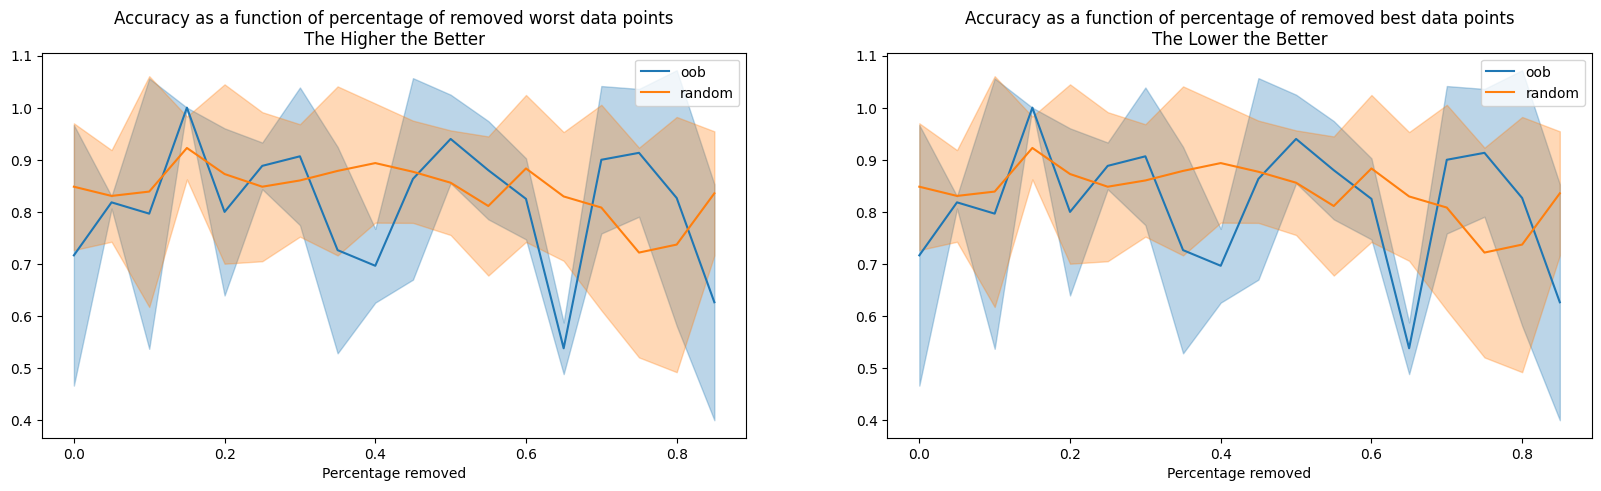

In [49]:
random_score = {pct:[] for pct in percentages}

for i,metric in enumerate(metric_list):
    for pct in percentages:
        for k in range(n_iter_random):
            n_removal = int(pct * len(sorted_df))
            train_data = sorted_df.sample(int(len(sorted_df)-n_removal))#.iloc[n_removal:]
            model = m().fit(train_data)
            gen_data = model.sample(30)[0]
            
            score = metric.compute(
                    real_data=pd.DataFrame(utility.data.x_test, columns = data.feature_names),
                    synthetic_data=pd.DataFrame(gen_data, columns = data.feature_names),
                )
            random_score[pct].append(score)
    
    all_scores = {pct:[] for pct in percentages}
    for pct in percentages:
        n_removal = int(pct * len(sorted_df))
        train_data = sorted_df.iloc[n_removal:]
        model = m().fit(train_data)
        for k in range(n_iter):
            gen_data = model.sample(30)[0]
            score = metric.compute(
                    real_data=pd.DataFrame(utility.data.x_test, columns = data.feature_names),
                    synthetic_data=pd.DataFrame(gen_data, columns = data.feature_names),
                )
            all_scores[pct].append(score)
    best_scores_df = pd.DataFrame(all_scores)
    best_scores_df.loc[:,"method_name"] = "_oob"

    df_random = pd.DataFrame(random_score)
    df_random.loc[:,"method_name"] = "_random"
    best_scores_df = pd.concat((best_scores_df, df_random))
    plot_best_worst(best_scores_df, best_scores_df)


In [43]:
best_scores_df = pd.DataFrame(all_scores)
best_scores_df.loc[:,"method_name"] = "_oob"

df_random = pd.DataFrame(random_score)
df_random.loc[:,"method_name"] = "_random"
best_scores_df = pd.concat((best_scores_df, df_random))
plot_best_worst(best_scores_df, best_scores_df)

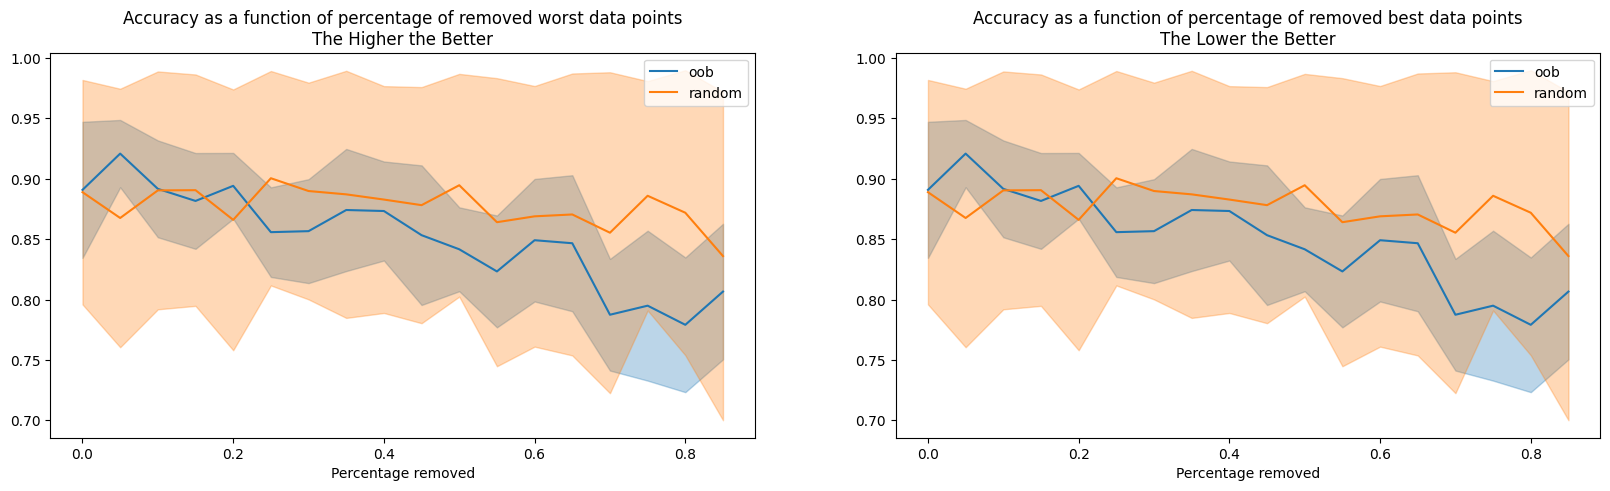

In [47]:
plot_best_worst(best_scores_df, best_scores_df)

### Reverse the order 

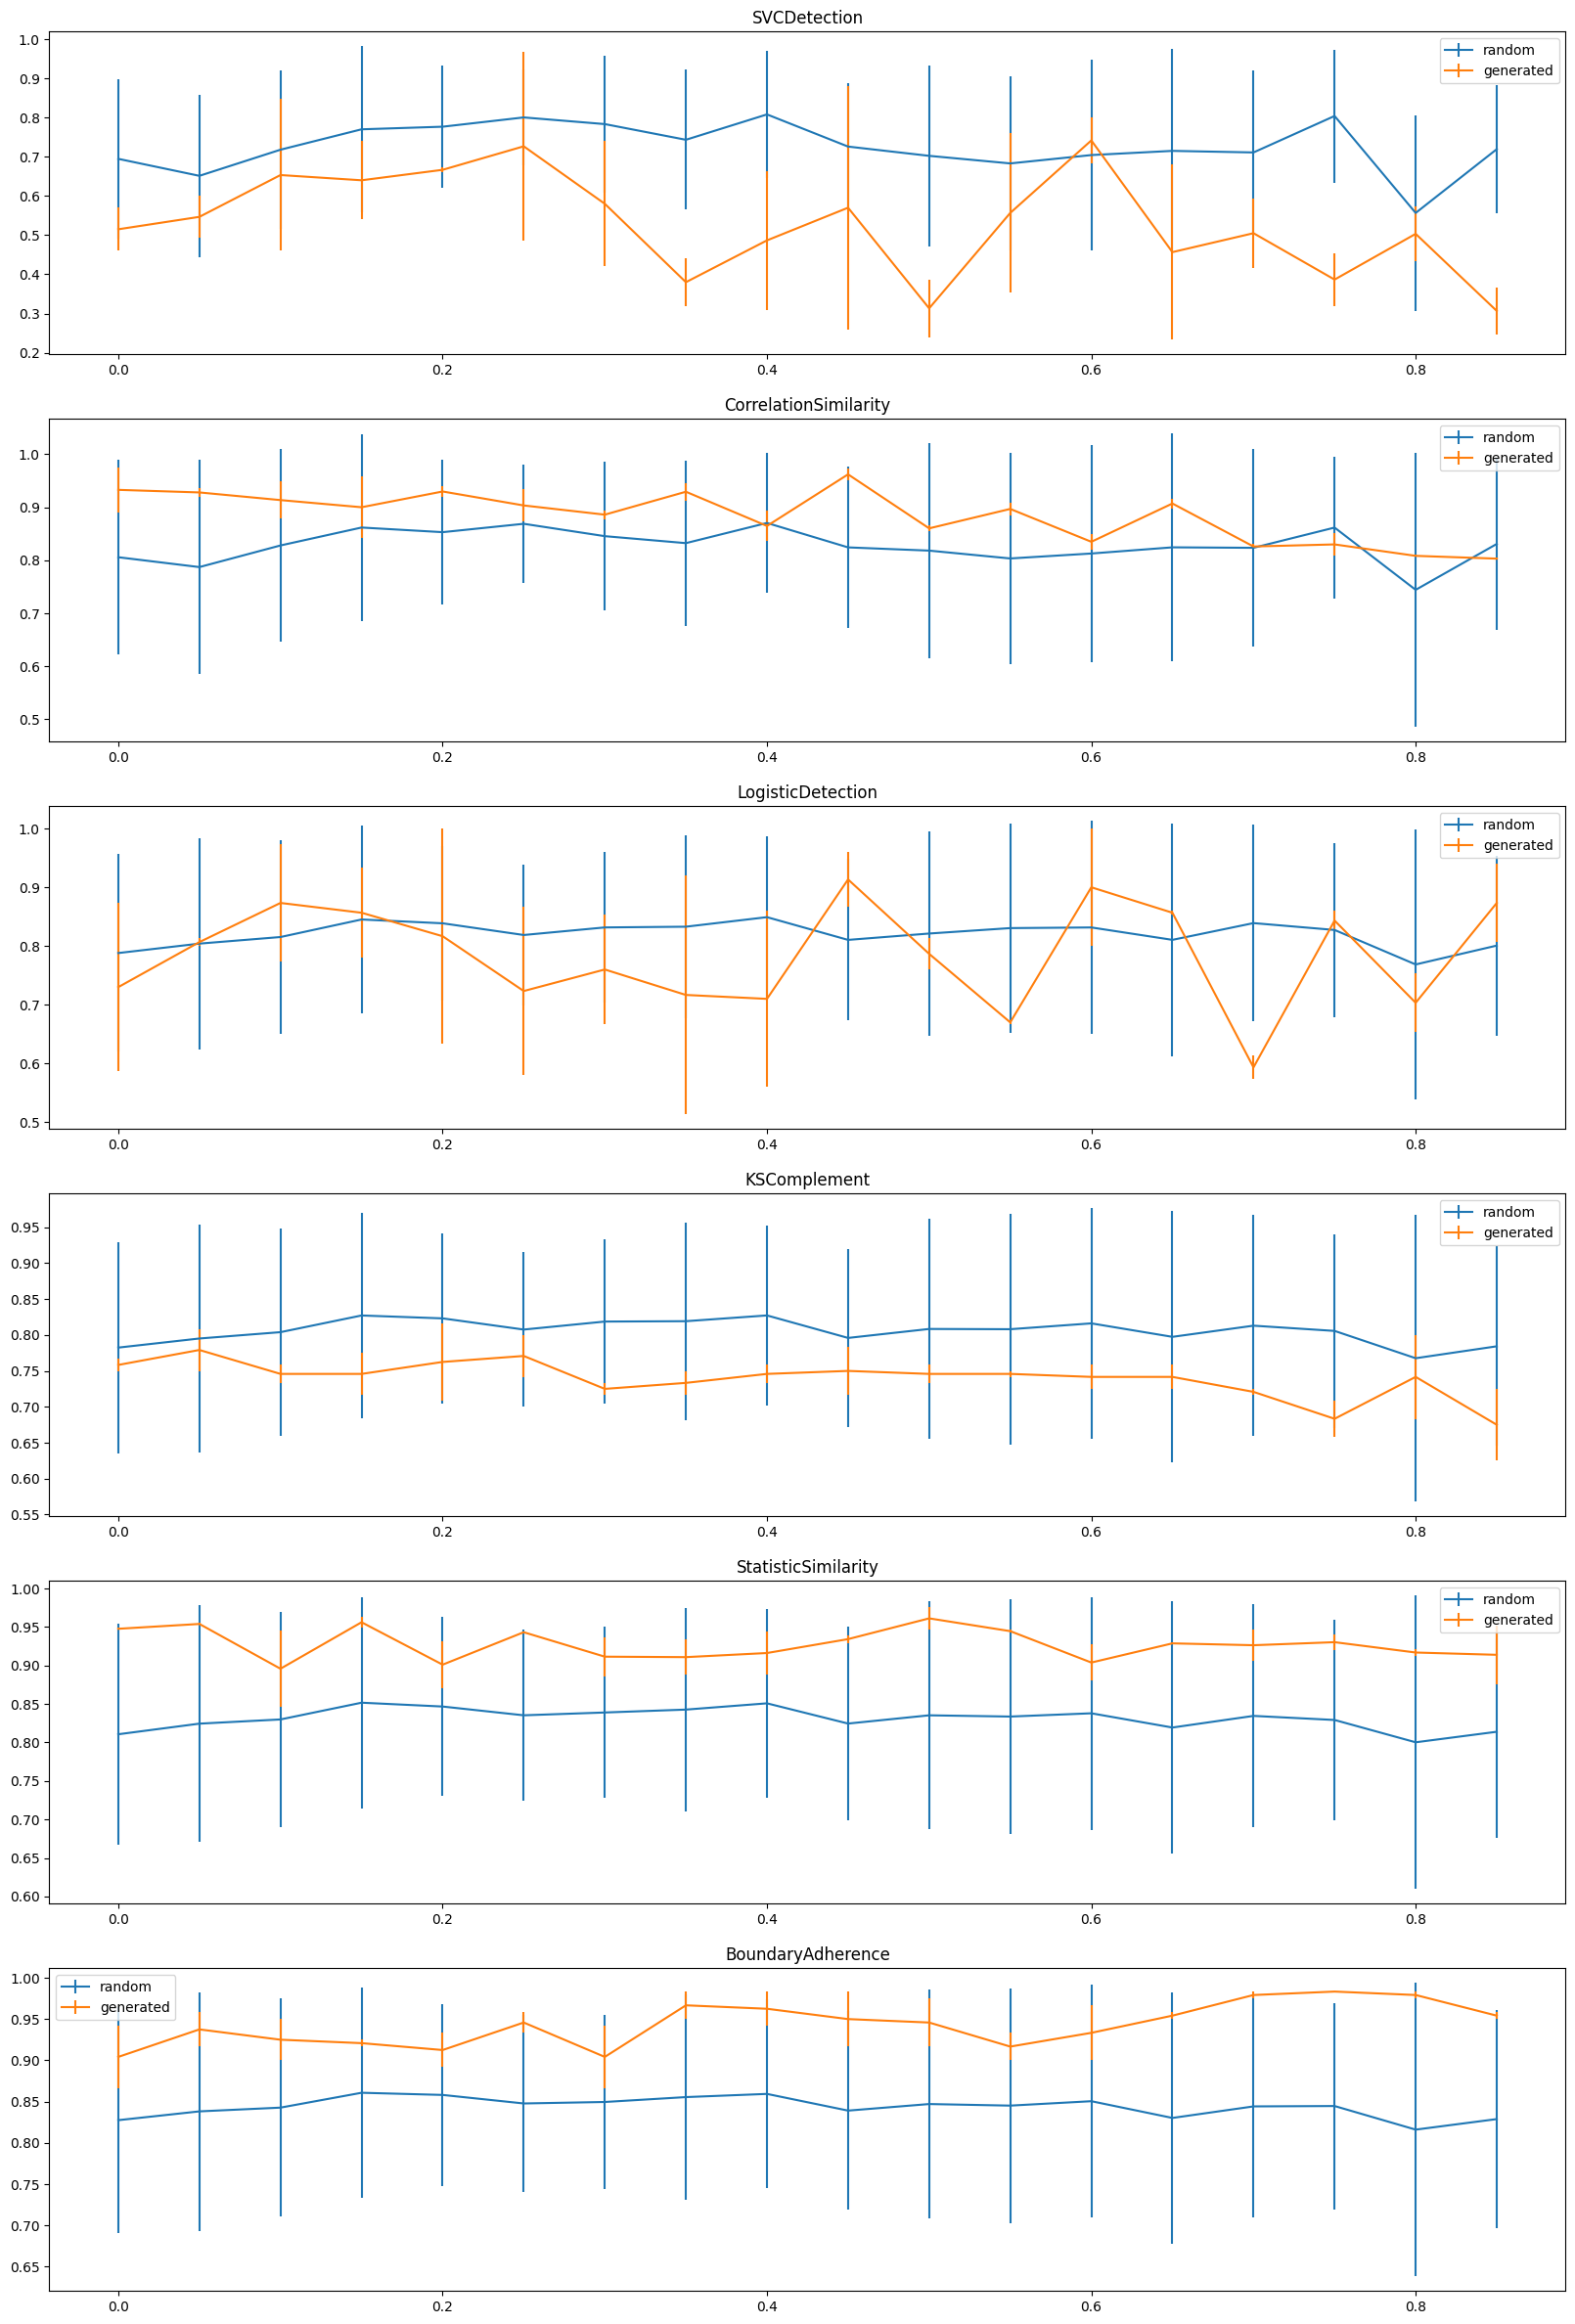

In [ ]:
sorted_df = df.sort_values(ascending=True, by="values").drop(columns = ['values'])

fig, ax = plt.subplots(ncols=1, nrows = len(metric_list), figsize = [20,5*len(metric_list)])

random_score = {pct:[] for pct in percentages}

for i,metric in enumerate(metric_list):
    for pct in percentages:
        for k in range(n_iter_random):
            n_removal = int(pct * len(sorted_df))
            train_data = sorted_df.sample(int(len(sorted_df)-n_removal))#.iloc[n_removal:]
            model = m().fit(train_data)
            gen_data = model.sample(30)[0]
            
            score = metric.compute(
                    real_data=pd.DataFrame(utility.data.x_test, columns = data.feature_names),
                    synthetic_data=pd.DataFrame(gen_data, columns = data.feature_names),
                )
            random_score[pct].append(score)
    
    ax[i].errorbar(x=percentages,y=[np.mean(x) for k,x in random_score.items()],
                        yerr=[np.std(x) for k,x in random_score.items()], label='random')

for i,metric in enumerate(metric_list):
    all_scores = {pct:[] for pct in percentages}
    for pct in percentages:
        n_removal = int(pct * len(sorted_df))
        train_data = sorted_df.iloc[n_removal:]
        model = m().fit(train_data)
        for k in range(n_iter):
            gen_data = model.sample(30)[0]
            score = metric.compute(
                    real_data=pd.DataFrame(utility.data.x_test, columns = data.feature_names),
                    synthetic_data=pd.DataFrame(gen_data, columns = data.feature_names),
                )
            all_scores[pct].append(score)
    ax[i].errorbar(x=percentages,y=[np.mean(x) for k,x in all_scores.items()],
                    yerr=[np.std(x) for k,x in all_scores.items()], label='generated')
    ax[i].set_title(metric.__name__)
    ax[i].legend()
plt.show()

# TODO: CHECK WHY THE START OF RANDOM AND GENERATED ARE NOT EQUAL !!!!

## TWo samples test

## CS TEST

In [ ]:
from sdmetrics.single_column import CSTest

In [ ]:
j=3
CSTest.compute(real_data= utility.data.x_train[:,j], synthetic_data = utility.data.x_test[:,j])

0.0

In [ ]:
data.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [ ]:
from sdmetrics.single_table import LogisticDetection

LogisticDetection.compute(
    real_data=pd.DataFrame(utility.data.x_train, columns = data.feature_names),
    synthetic_data=pd.DataFrame(utility.data.x_test, columns = data.feature_names),
)

0.865

## Compare with Loo

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sdv.metrics.tabular import CSTest

In [ ]:
all_scores = []
n_tries= 10
for i, x in df.iterrows():
    ov = x[-1]
    mean_score = 0
    for n in range(n_tries):
        train_set = df.drop(columns=['values']).sample(30)
        if(i in train_set.index):
            train_set = train_set.drop(i)
        mean_score += LogisticDetection.compute(
            real_data=train_set,
            synthetic_data=pd.DataFrame(utility.data.x_test, columns = data.feature_names),
        )
        
    all_scores.append(mean_score/n_tries)


In [ ]:
all_scores = []
n_tries= 20
for i, x in df.iterrows():
    ov = x[-1]
    mean_score = 0
    for n in range(n_tries):
        train_set = df.drop(columns=['values']).sample(100)
        if(i in train_set.index):
            train_set = train_set.drop(i)
        label_train_set = utility.data.y_train
        label_train_set = np.array(label_train_set)[train_set.index]
        eval_model = DecisionTreeClassifier().fit(train_set, label_train_set)
        mean_score += eval_model.score(data.x_test, data.y_test)
    all_scores.append(mean_score/n_tries)


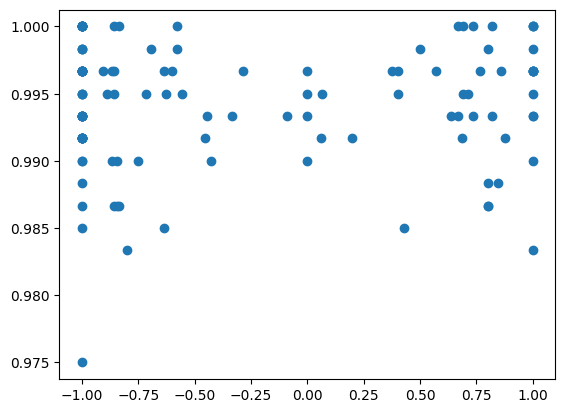

In [ ]:
plt.scatter(df.loc[:,"values"], all_scores)

<Axes: xlabel='values'>

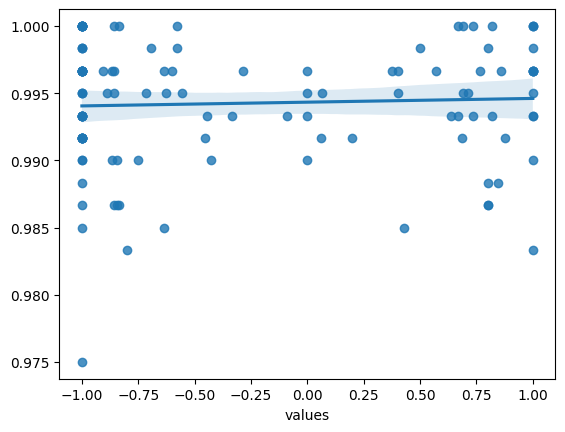

In [ ]:
sns.regplot(x=df.loc[:,"values"], y=all_scores)